<!--
---
title: "Classification"
author: "Madhura Killedar"
keypoints:
- Classification attempts to predict the class to which a particular observation belongs
- Scikit-learn has tons of classifier options
objectives: Learn how to build and evaluate classifiers
questions: How to classify?
source: ipynb
start: 0
teaching: 30
exercises: 0
---
-->

## Classification

## What is a classifier?

A classifier is some kind of rule / black box / widget that you can feed a new observation/data/record and it will decide whether or not it is part of a given class. E.g. below, we are classifying the animals to be either *cat* or *not cat*.

![A classifier for cats and not cats]("../fig/50-CatNotCat.jpg")

You can have classifiers for anything you can have a yes/no answer to, e.g.

- Is this a cat? 🐱
- Do these test results indicate cancer? 🚑
- Is this email spam or not spam? 📧

You can also have classifiers that categorise things into multiple (more than two) categories e.g.

- Which animal is this, out of the 12 animals I have trained my model on? 🐱
- Do these test results indicate {none, stage 1, stage 2, stage 3, stage 4} cancer? 🚑
- Is this email important, not important but not spam, or spam? 📧

It is clear that in some of these examples we are more concerned with being wrong in one direction than the other, e.g. it's better to let some spam email through accidentally than to block all of it but also junk important emails from people you know. Likewise, we would prefer our medical tests to err on the side of caution and not give a negative test result to someone who needs treatment. So we will need to adjust a parameter to decide how much we want to trade this off.

## Model evaluation (classification)

For now, let's imagine we have a classifier already. How can we test it to see how good it is?
A good start is a confusion matrix - a table of what test data it labels correctly and incorrectly.

![An demonstration of a confusion matrix for a cat classifier that has labelled 100 animals as cats or not-cats.]("../fig/50-CatConfusion.jpg")

### Confusion Matrix

When applying classification models, we often use a confusion matrix to evaluate certain performance measures. A confusion matrix is simply a matrix that compares "the truth" to the labels generated by your classifier. When we label a cat correctly, we refer to this as a true positive. When we fail to label a cat as a cat, this is called a false negative.  However, if we label something which is not a cat as a cat, this is called a false positive; and of course if we correctly label something which is not a cat, as not a cat, then this is a true negative.

### Some common metrics

![Error metrics](../fig/50-ErrorMetrics.png)

#### AUC: Area under the curve

A good classifier will have high precision and high specificity, minimizing both false positives and false negatives. In practice, and with an imperfect classifier, you can tune a knob to say which of those two you care more about. There will be some kind of a trade-off between the two.

To capture this balance, we often use a Receiver Operator Characteristic (ROC) curve that plots the false positive rate along the x-axis and the true positive rate along the y-axis, for all possible trade-offs. A line that is diagonal from the lower left corner to the upper right corner represents a random guess at labelling each example. The higher the line is in the upper left-hand corner, the better the classifier in general. AUC computes the area under this curve. For a perfect classifier, AUC = 1, for a random guess, AUC=0.5. Objective: maximize.

![A Receiver Operator Characteristic (ROC) curve, from which the Area Under the Curve (AUC) can be calculated.](../fig/50-CatArea.jpg)


# Pima Indians Diabetes
Today, we are going to be working with the [Pima Indians Diabetes Dataset](). This is a classic dataset from the UCI machine learning repository, which is now hosted on kaggle. We have downloaded the .csv file of this dataset from kaggle. It contains the following variables:



1) Pregnancies - Number of times pregnant
2) Glucose - Plasma glucose concentration a 2 hours in an [oral glucose tolerance test](https://en.wikipedia.org/wiki/Glucose_tolerance_test)
3) BloodPressure - Diastolic blood pressure (mm Hg)
4) SkinThickness - Triceps skin fold thickness (mm) - [a measure correlated with body fat](https://en.wikipedia.org/wiki/Anthropometry_of_the_upper_arm)
5) Insulin - 2-Hour serum insulin (mu U/ml)
6) BMI - Body mass index (weight in kg/(height in m)^2)
7) DiabetesPedigreeFunction - Diabetes pedigree function
8) Age - Age (years)
9) Outcome - diabetes status (1 - diabetic; 0 - non-diabetic)


The diabetes pedigree function was developed by [Smith 1988](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2245318/) to provide a synthesis ofthe diabetes mellitus history in relatives and the genetic relationship of those relatives to the subject. It uses information from parents, grandparents, siblings, aunts and uncles, and first cousin to provide a measure of the expected genetic influence of affected and unaffected relatives on the subject’s eventual diabetes risk:

![DiabetesPedigree](../fig/dpf.png)


- i - ranges across all relatives who HAD developed diabetes by subject's examination date
- j - ranges across all relatives who HAD NOT developed diabetes by subject's examination date
- Kx - percentage of genes shared by relative and subject. Equal to:
  - 0.5 when relative is parent or full sibling
  - 0.25 when relative is half-sibling, grandparent, aunt or uncle
  - 0.125 when relative is half aunt, half uncle or first cousin
- ADMi - age when diabetes was diagnosed
- ALC - age of relative when last "non-diabetic" assessment was made
- 88 and 14 - constants - maximum and minimum age at which patients in study were diagnosed with diabetes
- Constants 20 and 50 chosen so that:
  - A subject with no relatives has DPF slighly lower than average
  - DPF value decreases as young relatives free of diabetes join the database
  - DPF increases quickly as known relatives develop diabetes
  
DPF increases as:

- the number of relatives with diabetes increases
- the age at which those relatives develop diabetes decreases
- percentage of genes these relatives share with subject increase

DPF decreases as:

- the number of relatives who never develop diabetes increases
- their ages at last examination increase
- percentage of genes these relatives share with subject increase


## Let's Explore our data

In [144]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, accuracy_score, recall_score, precision_score 
from sklearn import model_selection
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
%matplotlib inline
sns.set(font_scale = 1.5)

### Load Data

In [13]:
diabetes = pd.read_csv('../data/diabetes.csv') # read csv

Explore the variables:

In [19]:
print(diabetes.columns)

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

Recode Outcome into integers

In [21]:
print(diabetes.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
Pregnancies                 768 non-null int64
Glucose                     768 non-null int64
BloodPressure               768 non-null int64
SkinThickness               768 non-null int64
Insulin                     768 non-null int64
BMI                         768 non-null float64
DiabetesPedigreeFunction    768 non-null float64
Age                         768 non-null int64
Outcome                     768 non-null int64
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None


### Summary info
Shape of data frame

In [22]:
diabetes.shape

(768, 9)

Look for missing data:

In [23]:
diabetes.count()

Pregnancies                 768
Glucose                     768
BloodPressure               768
SkinThickness               768
Insulin                     768
BMI                         768
DiabetesPedigreeFunction    768
Age                         768
Outcome                     768
dtype: int64

It seems like there is no missing data.
Get a summary of the data frame:

In [26]:
diabetes.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


> ## Challenge
>
> Look at the output of summary above and the table that explains what each of the variables are. Do the 
> values for all 
> - (a) Pregnancies and Glucose
> - (b) Blood pressure and Skin thickness
> - (c) Insulin and DiabetesPedigreeFunction, and
> - (d) BMI and Age 
> make sense?
>
> If not, how do you think we should deal with them? 
> Can you hypothesise what the consequences of this approach would be?
>
> {: .source}
>
> > ## Solution
> > 
> > ~~~
> >
> > # possibly missing
> > diabetes[diabetes == 0].count()
> > 
> > # not missing
> > diabetes[diabetes != 0].count()
> > 
> > ~~~
> > 
> > It is clear that the values of several variables are zero when it is impossible for them to be so (i.e. this value could not be zero if it was measured). Hence, we are dealing with "hidden" missing data, and should recode it as NA.
> > 
> > The following variables have zero "values" that are actually likely to be missing:
> > 
> > 1. Glucose (a)
> > 2. BloodPressure (b)
> > 3. SkinThickness (b)
> > 4. Insulin (c)
> > 5. BMI (d)
> > 
> > {: .output}
> {: .solution}
{: .challenge}

### Let’s use visualisation to further explore the dataset:

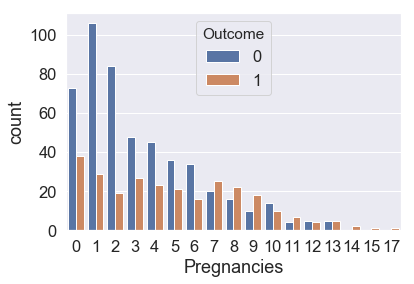

In [40]:
_ = sns.countplot(x="Pregnancies",
                hue="Outcome", 
                data=diabetes)


If we wanted to look at all possible scatterplot pairs we would do something like:

In [47]:
#catVars = diabetes.select_dtypes(include = ['object']).columns
numVars = diabetes.select_dtypes(exclude = ['object']).columns

In [50]:
diabetes['Outcome'].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

If we wanted to look at all possible scatterplot pairs we would do something like:

/Users/darya/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/darya/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/Users/darya/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


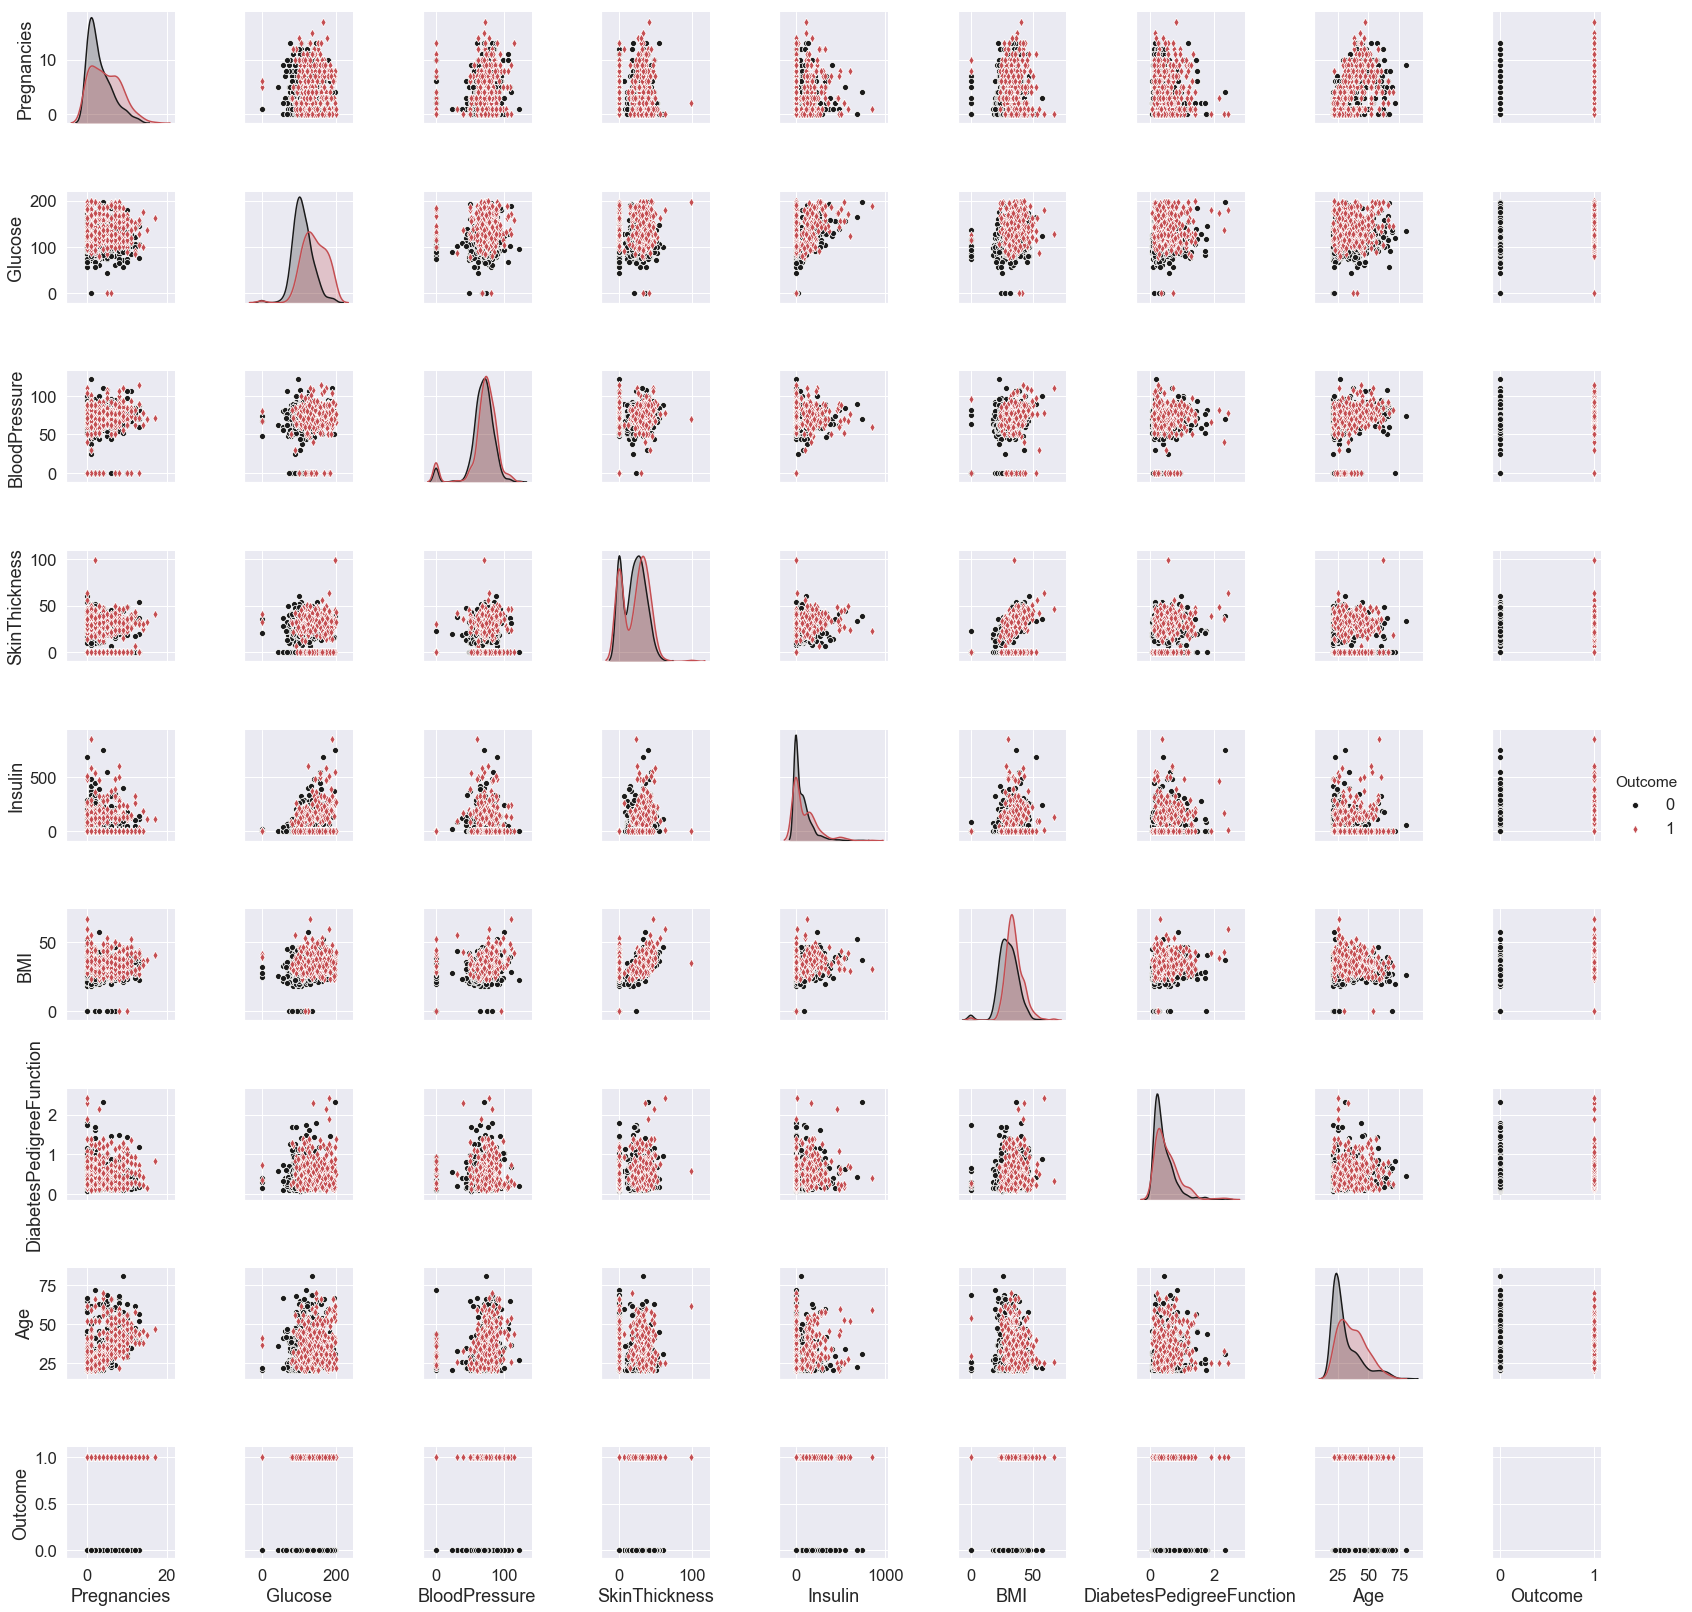

In [73]:
_ = sns.pairplot(data=diabetes,
                 vars=numVars,
                 hue='Outcome',
                 palette={0:'k',1:'r'},
                 # use kernel density estimates for univariate plots
                 diag_kind='kde',
                 # make the shape of points circular and diamond, respectively
                 markers=["o", "d"])

Generate a boxplot by possible prediction variables. Which do you hypothesize would me it easiest for us to separate the data?

/Users/darya/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


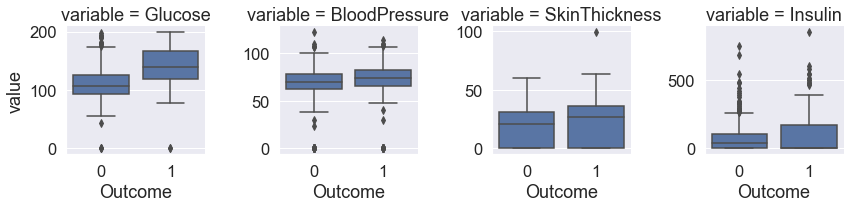

In [74]:
# copy the original dataframe
diabetes2 = diabetes.copy()
# create a new patient id column
diabetes2['PatientID'] = range(1, len(diabetes2) + 1)
# melt that dataframe
diabetes2 = diabetes2.melt(id_vars=['PatientID','Outcome'])

grid = sns.axisgrid.FacetGrid(diabetes2[diabetes2.variable.isin(numVars[1:5])], 
                              col='variable', 
                              # y axis scale different for each boxplot
                              sharey=False)
grid.map(sns.boxplot, 'Outcome','value')

/Users/darya/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


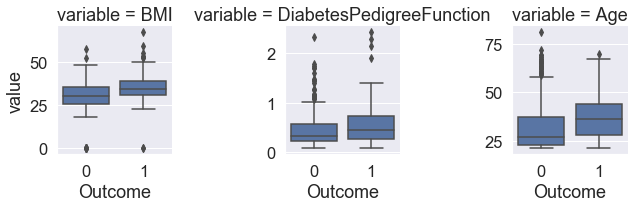

In [72]:
grid = sns.axisgrid.FacetGrid(diabetes2[diabetes2.variable.isin(numVars[5:])], 
                              col='variable', 
                               # y axis scale different for each boxplot
                              sharey=False)
grid.map(sns.boxplot, 'Outcome','value')

Make a correlation plot betwee all numeric variables

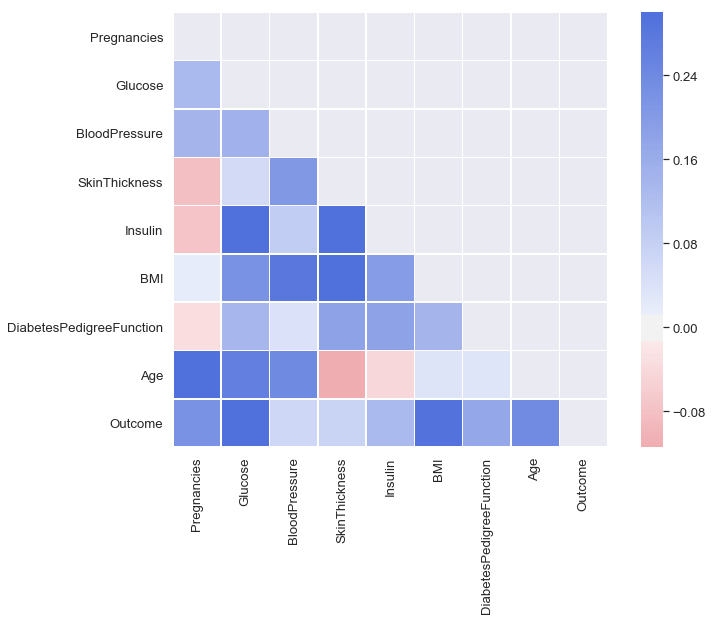

In [89]:
corr = diabetes.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
# hue_negative, hue_positive
cmap = sns.diverging_palette(10,260, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.set(rc={'figure.figsize':(12,8)})
sns.set(font_scale = 1.2)
_ = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0., square=True, linewidths=.5)

## Prepare Data

Let’s replace the missing values in the diabetes data frame with NaN.

In [101]:
# get the column names
diabetes.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [102]:
replaceVars = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin','BMI']

In [105]:
# mark zero values as missing or NaN
diabetes[replaceVars] = diabetes[replaceVars].replace(0, np.NaN)

In [108]:
print(diabetes.isnull().sum())

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64


Let’s generate a newcorrelation plot where the missing data has been properly recoded as NaN. Which correlations change?

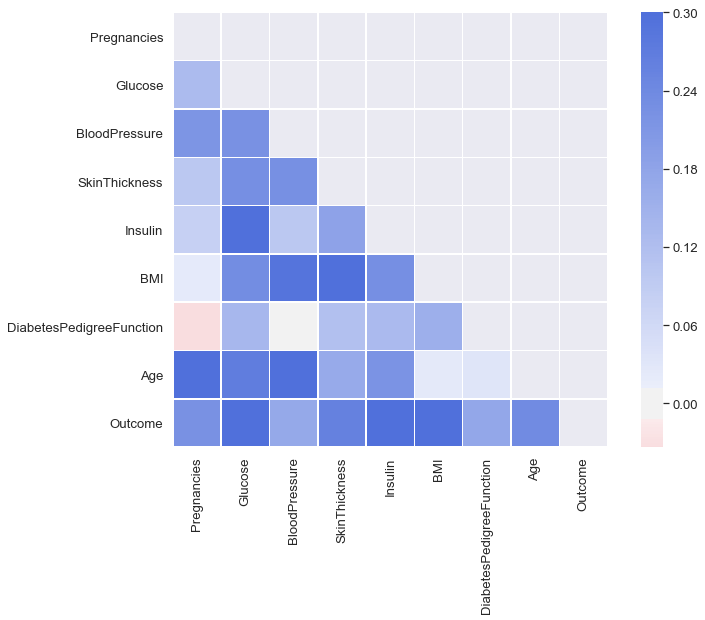

In [110]:
corr = diabetes.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
# hue_negative, hue_positive
cmap = sns.diverging_palette(10,260, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.set(rc={'figure.figsize':(12,8)})
sns.set(font_scale = 1.2)
_ = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0., square=True, linewidths=.5)

***
## Aim

To create a classifier for predicting whether a person has diabetes or not.

## Train-Test split

We’re going to split our data into 70% training and 30% testing sets.

In [116]:
rs = np.random.RandomState(42)
features_train, features_test, outcome_train, outcome_test = model_selection.train_test_split(diabetes[diabetes.columns.difference(['Outcome'])],diabetes['Outcome'], train_size=0.7, test_size=0.3)

How many examples do we have in the training and testing sets?

In [119]:
features_train.shape

(537, 8)

In [183]:
features_test.shape

(231, 8)

## Impute missing values using median values

In [184]:
## Impute missing information
imp_median = SimpleImputer(strategy='median') 
imp_median.fit(features_train)
features_train_imp = pd.DataFrame(imp_median.transform(features_train))
features_test_imp = pd.DataFrame(imp_median.transform(features_test))
features_train_imp.columns = features_train.columns
features_test_imp.columns = features_test.columns

Confirm that we have imputed the values for BOTH training and testing datasets using the TRAINING data median!

In [173]:
features_train.head()

,Age,BMI,BloodPressure,DiabetesPedigreeFunction,Glucose,Insulin,Pregnancies,SkinThickness
261,27,30.0,NaN,0.761,141.0,NaN,3,NaN
529,31,24.6,65.0,0.660,111.0,NaN,0,NaN
469,27,46.1,78.0,0.571,154.0,140.0,6,41.0
155,36,50.0,88.0,0.337,152.0,NaN,7,44.0
434,36,24.5,68.0,1.138,90.0,NaN,1,8.0


In [176]:
features_train_imp.head()

,Age,BMI,BloodPressure,DiabetesPedigreeFunction,Glucose,Insulin,Pregnancies,SkinThickness
0,27.0,30.0,72.0,0.761,141.0,130.0,3.0,29.0
1,31.0,24.6,65.0,0.660,111.0,130.0,0.0,29.0
2,27.0,46.1,78.0,0.571,154.0,140.0,6.0,41.0
3,36.0,50.0,88.0,0.337,152.0,130.0,7.0,44.0
4,36.0,24.5,68.0,1.138,90.0,130.0,1.0,8.0


In [180]:
features_test.tail()

,Age,BMI,BloodPressure,DiabetesPedigreeFunction,Glucose,Insulin,Pregnancies,SkinThickness
199,29,30.9,60.0,0.150,148.0,318.0,4,27.0
540,43,39.4,74.0,0.661,100.0,215.0,8,40.0
402,35,35.0,84.0,0.286,136.0,88.0,5,41.0
370,25,38.4,82.0,2.137,173.0,465.0,3,48.0
398,25,21.1,70.0,0.389,82.0,NaN,3,NaN


In [185]:
features_test_imp.tail()

,Age,BMI,BloodPressure,DiabetesPedigreeFunction,Glucose,Insulin,Pregnancies,SkinThickness
226,29.0,30.9,60.0,0.150,148.0,318.0,4.0,27.0
227,43.0,39.4,74.0,0.661,100.0,215.0,8.0,40.0
228,35.0,35.0,84.0,0.286,136.0,88.0,5.0,41.0
229,25.0,38.4,82.0,2.137,173.0,465.0,3.0,48.0
230,25.0,21.1,70.0,0.389,82.0,130.0,3.0,29.0


In [186]:
features_test.median()

Age                          29.000
BMI                          32.000
BloodPressure                72.000
DiabetesPedigreeFunction      0.385
Glucose                     119.000
Insulin                     115.000
Pregnancies                   3.000
SkinThickness                28.500
dtype: float64

### Standardize data ranges

In [187]:
StSc = StandardScaler()
features_train_sc = StSc.fit_transform(features_train_imp)
features_test_sc  = StSc.transform(features_test_imp)

### Recode outcome

In [188]:
training_true = outcome_train.astype("category").cat.codes.values
outcome_true = outcome_test.astype("category").cat.codes.values 
# code into 0's and 1's
# 0 is normal 
# 1 is diabetes
print((outcome_true == 0).sum())
print((outcome_true != 0).sum())

# 
print((training_true == 0).sum())
print((training_true != 0).sum())

# is our train/test balanced?
print((outcome_true != 0).sum()/(outcome_true == 0).sum())
print((training_true != 0).sum()/(training_true == 0).sum())

147
84
353
184
0.5714285714285714
0.5212464589235127


# Classifiers

## k-Nearest Neighbours Classifier

This takes the nearest k things and and says what is the majority vote? E.g. in the example below we look at the seven nearest neighbours, 4 of which are cats so we say that the new example is probably a cat as well.

![A way to classify a new example as a cat or not...take the average of the nearest k=7 examples. It's a cat!](../fig/50-CatKNN.jpg)


### Let's Classify!

Train KNN classifier

In [189]:
from sklearn.neighbors import KNeighborsClassifier
cf_knn= KNeighborsClassifier(n_neighbors=6)
fit_knn = cf_knn.fit(features_train_sc, outcome_train)

Use trained classifier to predict outcome for test-set

In [193]:
outcome_pred_class = cf_knn.predict(features_test_sc)
outcome_pred_prob = cf_knn.predict_proba(features_test_sc)
outcome_pred_prob1 = [p[1] for p in outcome_pred_prob] # hopefully close to 1 for true 1's

### Classifier Diagnostics/evaluation
So how well did the classifier do?

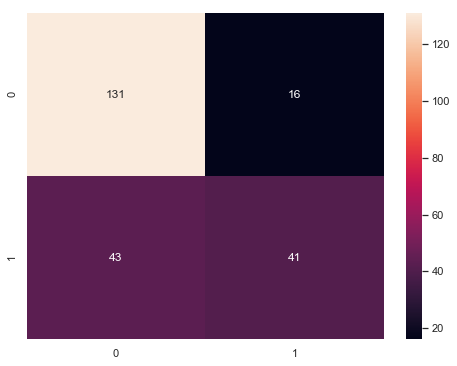

In [191]:
conf_mat = confusion_matrix(outcome_test, outcome_pred_class)
classes  = unique_labels(outcome_test, outcome_pred_class)
sns.set(rc={'figure.figsize':(8,6)})
_ = sns.heatmap(conf_mat, annot=True, fmt="d", xticklabels=classes, yticklabels=classes)

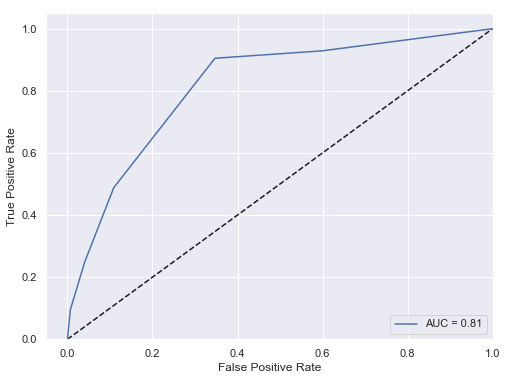

In [192]:
fpr, tpr, _ = roc_curve(outcome_true, outcome_pred_prob1)
AUC = roc_auc_score(outcome_true, outcome_pred_prob1)

def plot_ROC(fpr, tpr, AUC):
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='AUC = %4.2f'%AUC)
    _ = plt.legend(loc="lower right")
    
plot_ROC(fpr, tpr, AUC)

#### EXERCISE: 
How many neighbours are ideal?

## Naive Bayes Classifier

A Naïve Bayes classifier assumes that each of your columns are independent (uncorrelated with each other). It works out a probability that your example is a cat by counting the fraction of cats that had that value in each column, multiplying the values together and then multiplying again by what fraction of your training examples were cats. This is just writing out bayes rule of conditional probability and simplifying it for independent columns.

$$p(\text{Cat}| x_\text{new})=\frac{p(\text{Cat})p(x_\text{new}|\text{Cat})}{p(\text{Cat})p(x_\text{new}|\text{Cat})+p(\text{Not Cat})p(x_\text{new}|\text{Not Cat})}$$

In practice your columns are probably not independent, but we still use it anyway and it's usually ok, providing we only care about the label and not the probability it spits out.  

Continuous variables have to be somehow turned into discrete variables before you can use this technique, but most algorithms do this for you automatically.


### Let's Classify!
Train Naive Bayes classifier

In [26]:
from sklearn.naive_bayes import GaussianNB
cf_gnb = GaussianNB()
fit_gnb = cf_gnb.fit(features_train_sc, outcome_train)

Use trained classifier to predict outcome for test-set

In [27]:
outcome_pred_class = cf_gnb.predict(features_test_sc)

### Classifier Diagnostics
So how well did it go?

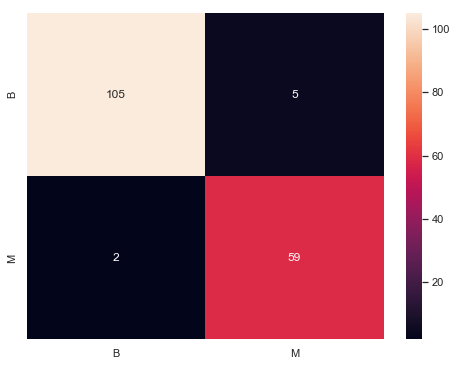

In [28]:
conf_mat = confusion_matrix(outcome_test, outcome_pred_class)
classes  = unique_labels(outcome_test, outcome_pred_class)
_ = sns.heatmap(conf_mat, annot=True, fmt="d", xticklabels=classes, yticklabels=classes)
#y_decision = knn.decision_function(features_test)

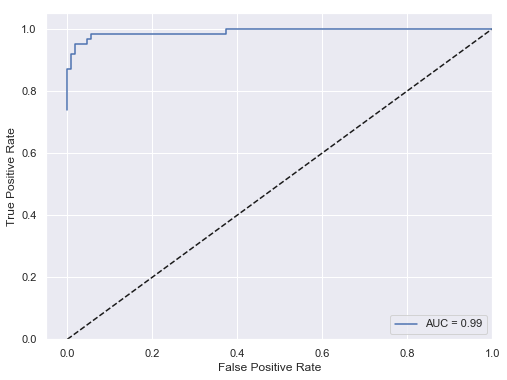

In [29]:
outcome_pred_prob = cf_gnb.predict_proba(features_test_sc)
outcome_pred_prob1 = [p[1] for p in outcome_pred_prob] # hopefully close to 1 for true 1's
fpr, tpr, _ = roc_curve(outcome_true, outcome_pred_prob1)
AUC = roc_auc_score(outcome_true, outcome_pred_prob1)
plot_ROC(fpr, tpr, AUC)

## Regularized Logistic Classifier

This fits a logistic regression to the probability of receiving a class label of 1 or 0. Regularisation (hopefully) stops it from overfitting. 

### Let's Classify!
Train Regularized Logistic classifier

In [30]:
from sklearn.linear_model import LogisticRegression
cf_rlc = LogisticRegression(random_state=74, solver='lbfgs', multi_class='ovr')
fit_rlc = cf_rlc.fit(features_train_sc, outcome_train)

Use trained classifier to predict outcome for test-set

In [31]:
outcome_pred_class = cf_rlc.predict(features_test_sc)
outcome_pred_prob = cf_rlc.predict_proba(features_test_sc)
outcome_pred_prob1 = [p[1] for p in outcome_pred_prob] # hopefully close to 1 for true 1's

### Classifier evaluation
So how well did the classifier do?

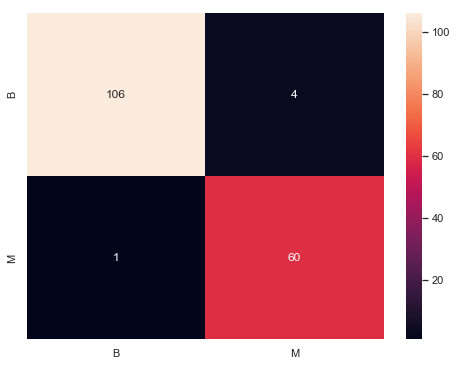

In [32]:
conf_mat = confusion_matrix(outcome_test, outcome_pred_class)
classes  = unique_labels(outcome_test, outcome_pred_class)
_ = sns.heatmap(conf_mat, annot=True, fmt="d", xticklabels=classes, yticklabels=classes)

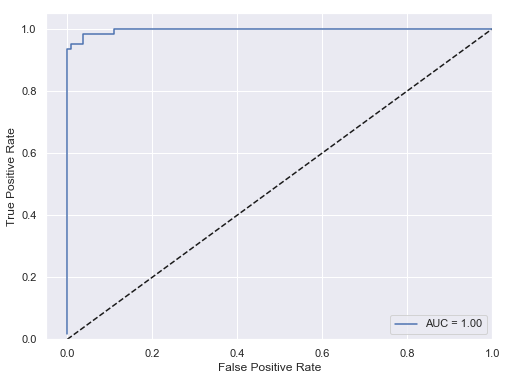

In [33]:
fpr, tpr, _ = roc_curve(outcome_true, outcome_pred_prob1)
AUC = roc_auc_score(outcome_true, outcome_pred_prob1)
plot_ROC(fpr, tpr, AUC)

## Decision Trees

A decision tree 🌳 picks the best split in the data greedily for each feature and basically makes a flowchart to follow with a new data point to say what you should classify it as. This makes them easy to understsand, but also usually not very accurate. 

### Let's Classify!
Train Decision Tree classifier

In [34]:
from sklearn.tree import DecisionTreeClassifier
cf_dtc = DecisionTreeClassifier()
fit_dtc = cf_dtc.fit(features_train_sc, outcome_train)

Use trained classifier to predict outcome for test-set

In [35]:
outcome_pred_class = cf_dtc.predict(features_test_sc)
outcome_pred_prob = cf_dtc.predict_proba(features_test_sc)
outcome_pred_prob1 = [p[1] for p in outcome_pred_prob] # hopefully close to 1 for true 1's

### Classifier evaluation
So how well did the classifier do?

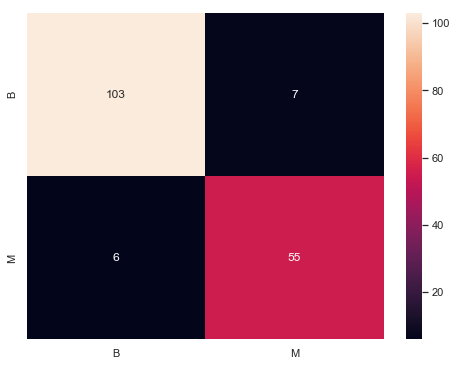

In [36]:
conf_mat = confusion_matrix(outcome_test, outcome_pred_class)
classes  = unique_labels(outcome_test, outcome_pred_class)
_ = sns.heatmap(conf_mat, annot=True, fmt="d", xticklabels=classes, yticklabels=classes)

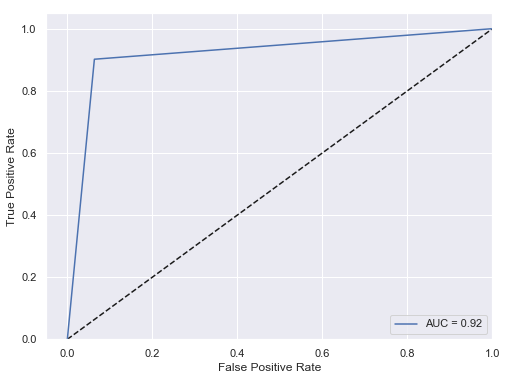

In [37]:
fpr, tpr, _ = roc_curve(outcome_true, outcome_pred_prob1)
AUC = roc_auc_score(outcome_true, outcome_pred_prob1)
plot_ROC(fpr, tpr, AUC)

## Random Forest Classifier
A random decision tree is where you make a decision tree but only train it on either (a) a random sample of the available data or (b) a random sample of the available features or (c) both.

A random forest is a whole bunch of these averaged together. 

Turns out these do pretty good and are used all over the place. But because they're the average of so many different models it's hard to get an understanding about it. It's basically a black box that predicts well.

In [38]:
from sklearn.ensemble import RandomForestClassifier
cf_rfc = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
fit_rfc = cf_rfc.fit(features_train_sc, outcome_train)

Use trained classifier to predict outcome for test-set

In [39]:
outcome_pred_class = cf_rfc.predict(features_test_sc)
outcome_pred_prob = cf_rfc.predict_proba(features_test_sc)
outcome_pred_prob1 = [p[1] for p in outcome_pred_prob] # hopefully close to 1 for true 1's

### Classifier evaluation
So how well did the classifier do?

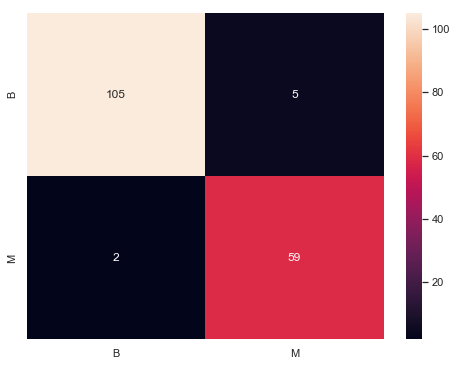

In [40]:
conf_mat = confusion_matrix(outcome_test, outcome_pred_class)
classes  = unique_labels(outcome_test, outcome_pred_class)
_ = sns.heatmap(conf_mat, annot=True, fmt="d", xticklabels=classes, yticklabels=classes)

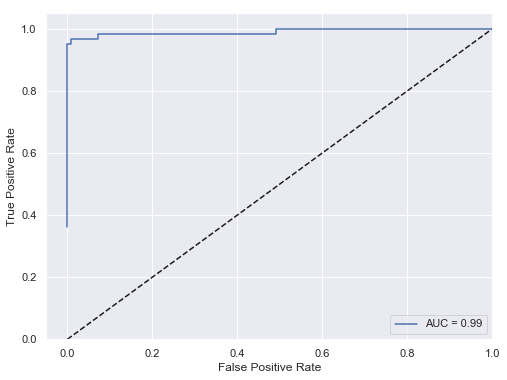

In [41]:
fpr, tpr, _ = roc_curve(outcome_true, outcome_pred_prob1)
AUC = roc_auc_score(outcome_true, outcome_pred_prob1)
plot_ROC(fpr, tpr, AUC)

#### EXERCISE: 
What max_depth is ideal?

## Support Vector Machine
A support vector machine tries to find the data points right on the boundary between the two classes (the "support vectors") and then uses them to define a maximum margin boundary.

![A linear Support Vector Machine for Cats](../fig/50-CatSVM.jpg)

### Let's Classify!
Train SVM

In [42]:
from sklearn import svm
cf_svm = svm.LinearSVC()
fit_svm = cf_svm.fit(features_train_sc, outcome_train)

Use trained classifier to predict outcome for test-set

In [43]:
outcome_pred_class = cf_svm.predict(features_test_sc)

SVM DOESN'T CALCULATE PROBABILITIES!

### Classifier evaluation
So how well did the classifier do?

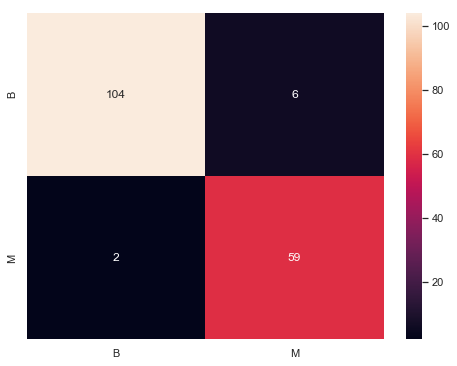

In [44]:
conf_mat = confusion_matrix(outcome_test, outcome_pred_class)
classes  = unique_labels(outcome_test, outcome_pred_class)
_ = sns.heatmap(conf_mat, annot=True, fmt="d", xticklabels=classes, yticklabels=classes)

# Compare all the classifiers

In [51]:
evaluations = ['Misclassification rate', 'Sensitivity', 'Specificity', 'AUC']
pretrained_models = {'k Nearest Neighbours':cf_knn, 'Naive Bayes':cf_gnb, 'Regularised Logistic Classifier':cf_rlc, 'Decision Tree':cf_dtc, 'Random Forest':cf_rfc, 'Support Vector Machine':cf_svm}
comparison_stats = pd.DataFrame(index = pretrained_models.keys(), columns=evaluations)
for method, model in pretrained_models.items():
    outcome_pred_class = model.predict(features_test_sc)
    if method in ['Support Vector Machine']:
        AUC = float('nan')
    else:
        outcome_pred_prob = model.predict_proba(features_test_sc)
        outcome_pred_prob1 = [p[1] for p in outcome_pred_prob]
        AUC = roc_auc_score(outcome_true, outcome_pred_prob1)
    conf_mat = confusion_matrix(outcome_test, outcome_pred_class)
    comparison_stats.loc[method,'Misclassification rate']  = 1. - accuracy_score(outcome_test, outcome_pred_class)
    comparison_stats.loc[method,'Sensitivity'] = conf_mat[1,1]/np.sum(conf_mat[1,:])
    comparison_stats.loc[method,'Specificity'] = conf_mat[0,0]/np.sum(conf_mat[0,:])
    comparison_stats.loc[method,'AUC'] = AUC

In [52]:
comparison_stats.round(decimals=3)

,Misclassification rate,Sensitivity,Specificity,AUC
k Nearest Neighbours,0.0233918,0.934426,1,0.993815
Naive Bayes,0.0409357,0.967213,0.954545,0.991207
Regularised Logistic Classifier,0.0292398,0.983607,0.963636,0.99687
Decision Tree,0.0760234,0.901639,0.936364,0.919001
Random Forest,0.0409357,0.967213,0.954545,0.990611
Support Vector Machine,0.0467836,0.967213,0.945455,NaN


What do you think?